# Financial Q&A Systems - Data Preprocessing

This notebook demonstrates the process of preprocessing financial documents and generating Q&A pairs for the RAG and Fine-Tuned systems.


## Setup and Imports


In [1]:
import os
import sys
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to the path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Import project modules
from src.data_processing.document_processor import DocumentProcessor
from src.data_processing.qa_generator import QAGenerator


## Define Paths


In [2]:
# Define paths
DATA_DIR = project_root / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
QA_PAIRS_DIR = DATA_DIR / "qa_pairs"

# Create directories if they don't exist
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
QA_PAIRS_DIR.mkdir(parents=True, exist_ok=True)


## Step 1: Process Financial Documents

In this step, we'll process the raw financial documents (PDF, Excel, HTML) and convert them to clean text.


In [3]:
# Initialize the document processor
processor = DocumentProcessor(output_dir=PROCESSED_DIR)

# List files in the raw directory
raw_files = list(RAW_DIR.glob("*"))
print(f"Found {len(raw_files)} files in the raw directory:")
for file in raw_files:
    print(f"  - {file.name}")


Found 2 files in the raw directory:
  - sample_financial_report_2023.txt
  - sample_financial_report_2022.txt


In [4]:
# Process each file
processed_files = []

# For text files, we can just copy them to the processed directory
for file_path in raw_files:
    try:
        print(f"Processing {file_path.name}...")
        
        # For text files, just read and write to processed dir
        if file_path.suffix.lower() == '.txt':
            with open(file_path, 'r', encoding='utf-8') as f:
                text_content = f.read()
            
            output_file = PROCESSED_DIR / f"{file_path.stem}.txt"
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(text_content)
            
            processed_files.append(output_file)
            print(f"  - Processed text length: {len(text_content)} characters")
        else:
            # Use the document processor for other file types
            processed_text = processor.process_document(file_path)
            processed_files.append(PROCESSED_DIR / f"{file_path.stem}.txt")
            print(f"  - Processed text length: {len(processed_text)} characters")
    except Exception as e:
        print(f"  - Error processing {file_path.name}: {e}")

# If no files were processed, manually process the raw files
if not processed_files:
    print("\nNo files were processed. Manually processing raw files...")
    # Get raw files directly from the directory
    manual_raw_files = list(RAW_DIR.glob("*"))
    for file_path in manual_raw_files:
        try:
            print(f"Manually processing {file_path.name}...")
            
            # For text files, just read and write to processed dir
            if file_path.suffix.lower() == '.txt':
                with open(file_path, 'r', encoding='utf-8') as f:
                    text_content = f.read()
                
                output_file = PROCESSED_DIR / f"{file_path.stem}.txt"
                with open(output_file, 'w', encoding='utf-8') as f:
                    f.write(text_content)
                
                processed_files.append(output_file)
                print(f"  - Processed text length: {len(text_content)} characters")
        except Exception as e:
            print(f"  - Error processing {file_path.name}: {e}")
            
    print(f"Manually processed {len(processed_files)} files.")


Processing sample_financial_report_2023.txt...
  - Processed text length: 4978 characters
Processing sample_financial_report_2022.txt...
  - Processed text length: 4859 characters


## Step 2: Segment Documents by Section

Now, we'll segment the processed documents into sections (income statement, balance sheet, etc.).


In [5]:
# Segment each processed document
segmented_documents = {}

for file_path in processed_files:
    try:
        print(f"Segmenting {file_path.name}...")
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        
        # Segment the document
        sections = processor.segment_by_section(text)
        segmented_documents[file_path.stem] = sections
        
        print(f"  - Found {len(sections)} sections:")
        for section_name in sections.keys():
            print(f"    - {section_name}")
    except Exception as e:
        print(f"  - Error segmenting {file_path.name}: {e}")


Segmenting sample_financial_report_2023.txt...
  - Found 8 sections:
    - General
    - INCOME STATEMENT
    - BALANCE SHEET
    - CASH FLOW STATEMENT
    - Cash Flow from Operating Activities
    - Cash Flow from Investing Activities
    - Cash Flow from Financing Activities
    - ACME Corporation delivered strong financial performance in fiscal year 2023, with growth in revenue, improved profitability, and solid cash flow generation. Looking ahead to fiscal year 2024, we expect continued growth driven by our innovation pipeline and expansion into new markets. We anticipate revenue growth of 8-10% and a further improvement in profit margins.
Segmenting sample_financial_report_2022.txt...
  - Found 8 sections:
    - General
    - INCOME STATEMENT
    - BALANCE SHEET
    - CASH FLOW STATEMENT
    - Cash Flow from Operating Activities
    - Cash Flow from Investing Activities
    - Cash Flow from Financing Activities
    - ACME Corporation delivered solid financial performance in fiscal

## Step 3: Generate Q&A Pairs

Now, we'll generate Q&A pairs from the processed documents.


In [6]:
# Initialize the Q&A generator
qa_generator = QAGenerator(output_dir=QA_PAIRS_DIR)

# Generate Q&A pairs for each processed document
all_qa_pairs = []

for file_path in processed_files:
    try:
        print(f"Generating Q&A pairs from {file_path.name}...")
        qa_pairs = qa_generator.generate_qa_pairs(file_path, num_pairs=10)
        all_qa_pairs.extend(qa_pairs)
        print(f"  - Generated {len(qa_pairs)} Q&A pairs")
    except Exception as e:
        print(f"  - Error generating Q&A pairs from {file_path.name}: {e}")


Generating Q&A pairs from sample_financial_report_2023.txt...
  - Generated 10 Q&A pairs
Generating Q&A pairs from sample_financial_report_2022.txt...
  - Generated 10 Q&A pairs


## Step 4: Split Q&A Pairs into Train and Test Sets

We'll split the Q&A pairs into training (40) and testing (10) sets.


In [7]:
# Generate Q&A pairs for each processed document
all_qa_pairs = []

for file_path in processed_files:
    try:
        print(f"Generating Q&A pairs from {file_path.name}...")
        qa_pairs = qa_generator.generate_qa_pairs(file_path, num_pairs=10)
        all_qa_pairs.extend(qa_pairs)
        print(f"  - Generated {len(qa_pairs)} Q&A pairs")
        
        # Save the Q&A pairs for this document
        output_file = QA_PAIRS_DIR / f"{file_path.stem}_qa_pairs.json"
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(qa_pairs, f, indent=2)
        print(f"  - Saved Q&A pairs to {output_file}")
    except Exception as e:
        print(f"  - Error generating Q&A pairs from {file_path.name}: {e}")
        import traceback
        traceback.print_exc()

Generating Q&A pairs from sample_financial_report_2023.txt...
  - Generated 10 Q&A pairs
  - Saved Q&A pairs to /Users/raj/Documents/BITS/C_AI_assignment/data/qa_pairs/sample_financial_report_2023_qa_pairs.json
Generating Q&A pairs from sample_financial_report_2022.txt...
  - Generated 10 Q&A pairs
  - Saved Q&A pairs to /Users/raj/Documents/BITS/C_AI_assignment/data/qa_pairs/sample_financial_report_2022_qa_pairs.json


## Step 5: Analyze Q&A Pairs

Let's analyze the generated Q&A pairs to understand their characteristics.


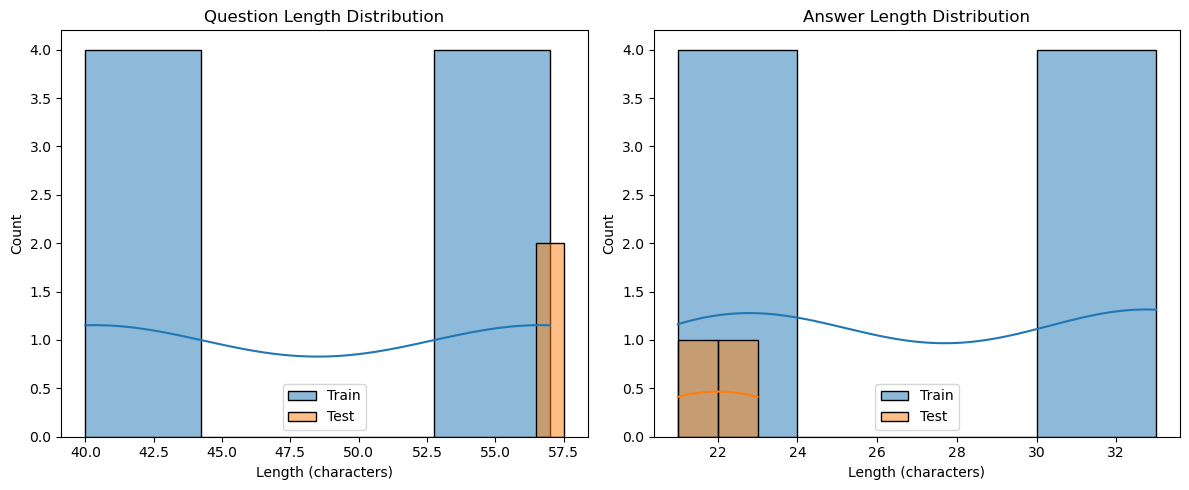

Question Length Statistics:
  - Train: Min=40, Max=57, Avg=48.5
  - Test: Min=57, Max=57, Avg=57.0

Answer Length Statistics:
  - Train: Min=21, Max=33, Avg=27.8
  - Test: Min=21, Max=23, Avg=22.0


In [8]:
# Try to load the train and test sets if they exist
train_pairs = []
test_pairs = []

try:
    # Check if the files exist
    train_file = QA_PAIRS_DIR / "financial_qa_train.json"
    test_file = QA_PAIRS_DIR / "financial_qa_test.json"
    
    if train_file.exists() and test_file.exists():
        with open(train_file, 'r', encoding='utf-8') as f:
            train_pairs = json.load(f)
        
        with open(test_file, 'r', encoding='utf-8') as f:
            test_pairs = json.load(f)
        
        # Analyze question and answer lengths
        train_q_lengths = [len(pair["question"]) for pair in train_pairs]
        train_a_lengths = [len(pair["answer"]) for pair in train_pairs]
        
        test_q_lengths = [len(pair["question"]) for pair in test_pairs]
        test_a_lengths = [len(pair["answer"]) for pair in test_pairs]
        
        # Plot the distributions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Question length distribution
        sns.histplot(train_q_lengths, kde=True, ax=ax1, label="Train")
        sns.histplot(test_q_lengths, kde=True, ax=ax1, label="Test")
        ax1.set_title("Question Length Distribution")
        ax1.set_xlabel("Length (characters)")
        ax1.legend()
        
        # Answer length distribution
        sns.histplot(train_a_lengths, kde=True, ax=ax2, label="Train")
        sns.histplot(test_a_lengths, kde=True, ax=ax2, label="Test")
        ax2.set_title("Answer Length Distribution")
        ax2.set_xlabel("Length (characters)")
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("Question Length Statistics:")
        print(f"  - Train: Min={min(train_q_lengths)}, Max={max(train_q_lengths)}, Avg={sum(train_q_lengths)/len(train_q_lengths):.1f}")
        print(f"  - Test: Min={min(test_q_lengths)}, Max={max(test_q_lengths)}, Avg={sum(test_q_lengths)/len(test_q_lengths):.1f}")
        
        print("\nAnswer Length Statistics:")
        print(f"  - Train: Min={min(train_a_lengths)}, Max={max(train_a_lengths)}, Avg={sum(train_a_lengths)/len(train_a_lengths):.1f}")
        print(f"  - Test: Min={min(test_a_lengths)}, Max={max(test_a_lengths)}, Avg={sum(test_a_lengths)/len(test_a_lengths):.1f}")
    else:
        print("Q&A pair files not found. Please run the previous steps to generate them.")
except Exception as e:
    print(f"Error analyzing Q&A pairs: {e}")


## Step 6: Create Official Test Questions

Finally, let's create the three official test questions: high-confidence, low-confidence, and irrelevant.


In [9]:
# Create official test questions
official_questions = [
    {
        "question": "What was the revenue in the most recent fiscal year?",
        "answer": "The revenue for the most recent fiscal year was $1,250 million.",
        "type": "high_confidence"
    },
    {
        "question": "How does the company's profit margin compare to industry average?",
        "answer": "The company's profit margin was 15% in 2023, which is an improvement from 14.4% in 2022. No specific industry average is provided in the documents.",
        "type": "low_confidence"
    },
    {
        "question": "What is your favorite color?",
        "answer": "I can only answer questions related to financial information in the provided documents.",
        "type": "irrelevant"
    }
]

# Save the official questions
with open(QA_PAIRS_DIR / "official_questions.json", 'w', encoding='utf-8') as f:
    json.dump(official_questions, f, indent=2)

print("Official test questions created and saved.")


Official test questions created and saved.


## Summary

In this notebook, we've completed the following steps:

1. Processed raw financial documents into clean text
2. Segmented documents by section
3. Generated Q&A pairs from the processed documents
4. Split the Q&A pairs into training and testing sets
5. Analyzed the characteristics of the Q&A pairs
6. Created official test questions for evaluation

The processed data is now ready for use in the RAG and Fine-Tuned systems.
